In [344]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: '%.3f' % x)
pd.set_option("display.width", 500)

In [345]:
def load_application_train():
    data = pd.read_csv("datasets/application_train.csv")
    return data

In [346]:
def load():
    data = pd.read_csv("datasets/titanic.csv")
    return data

In [453]:
def catch_outliers(dataframe, num_col, q1=0.25, q3=0.75):
    quartile1 = dataframe[num_col].quantile(q1)
    quartile3 = dataframe[num_col].quantile(q3)
    iqr = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr

    # outliers = [dataframe[(dataframe[num_col] < low) | (dataframe[num_col] > up)]]
    return low_limit, up_limit


def check_outlier(dataframe, num_col):
    low_limit, up_limit = catch_outliers(dataframe, num_col)

    if dataframe[(dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit)].any(axis=None):
        return True
    else:
        return False

    
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.

    Parameters
    ----------
    dataframe: dataframe
        Değişken isimleri alınmak istenen dataframe'dir.
    cat_th: int, float
        Numerik fakat kategorik olan değişkenler için sınıf eşik değeri.
    car_th: int, float
        Kategorik fakat kardinal değişkenler için sınıf eşik değeri.

    Returns
    -------
    cat_cols: list
        Kategorik değişken listesi.
    num_cols: list
        Numerik değişken listesi.
    cat_but_car: list
        Kategorik görünümlü kardinal değişken listesi.

    Notes
    ------
    cat_cols + num_cols + cat_but_car = toplam değişken sayısı
    num_but_cat, cat_cols'un içerisinde.

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["object", "category", "bool"]]

    num_but_cats = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8", "int32", "int64", "float64"] and
                    dataframe[col].nunique() < cat_th]

    cat_but_cars = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["object", "category"] and
                    dataframe[col].nunique() > car_th]

    cat_cols = cat_cols + num_but_cats

    cat_cols = [col for col in cat_cols if col not in cat_but_cars]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cats]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_cars)}")
    print(f"num_but_cat: {len(num_but_cats)}")

    return cat_cols, num_cols, cat_but_cars


def reach_outliers(dataframe, num_col, index=False):
    up_limit, low_limit = catch_outliers(dataframe, num_col)

    if len(dataframe[(dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit)]) > 10:
        print(dataframe[(dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit)].head())
    else:
        print(dataframe[(dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit)])

    if index:
        return dataframe[(dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit)].index


def remove_outliers(dataframe, num_col):
    up_limit, low_limit = catch_outliers(dataframe, num_col)
    df_without_outliers = dataframe[~((dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit))]

    return df_without_outliers


def replace_with_thresholds(dataframe, num_col):
    low_limit, up_limit = catch_outliers(dataframe, num_col)

    dataframe.loc[(dataframe[num_col] < low_limit), num_col] = low_limit
    dataframe.loc[(dataframe[num_col] > up_limit), num_col] = up_limit
    
def missing_values_table(dataframe, na_name=False):
    # eksik veri bulunduran değişkenlerin seçilmesi
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    
    # değişkenlerdeki eksik değer miktarı
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    # değişkenlerdeki eksik değer oranı
    ratio = (dataframe[na_columns].isnull().sum() / len(dataframe) * 100).sort_values(ascending=False)
    
    # yukardaki hesapladığımız miktar ve oran bilgilerini içeren bir df oluşturulması
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    
    print(missing_df, end='\n')
    
    if na_name:
        return na_columns
    
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    # fonksiyona girilen dataframe içerisinden kategorik değişkenleri one hot encoding işlemine sokuyoruz
    # sonrasında ana dataframe'e bunu kaydederek fonksiyon sonunda bu df'i döndürüyoruz.
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts())) # değişkenin içerisinde kaç tane sınıf var?
        
        # değişkendeki sınıfların toplamları, oranları ve target değişkenine göre oranlarını veren dataframe
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                           "RATIO": dataframe[col].value_counts() / len(dataframe),
                           "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

def rare_encoder(dataframe, rare_perc):
    # dataframe'in kopyasını aldık
    temp_df = dataframe.copy()
    
    # eğer değişken kategorikse ve içerisindeki sınıflardan herhangi birisinin oranı rare_perc'de verilen orandan az ise 
    # bu değişkeni rare_columns'a ata
    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O' and 
                    (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]
    
    for var in rare_columns: # seçilen rare değişkenler içerisinde gez
        tmp = temp_df[var].value_counts() / len(temp_df) # temp_df de var değişkeninin oranını al
        rare_labels = tmp[tmp < rare_perc].index # eğer alınan oran rare_perc'den küçükse bunun label'ını al
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), "Rare", temp_df[var]) # bu label yerine 'Rare' yazdır
        
    return temp_df

# Titanic Uçtan Uca Feature Engineering & Data Preprocessing

In [454]:
df = load()

In [455]:
df.shape

(891, 12)

In [456]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


Öncelikle dataframe içindeki değişkenlerin isimlerini, hepsi büyük harfle yazılacak şekilde değiştirelim.

In [457]:
df.columns = [col.upper() for col in df.columns]

In [458]:
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


## 1. Feature Engineering

Uygulamanın öncesinde oluşturduğumuz değişkenleri şimdi burada tekrar uygulayalım.

<b>Cabin Bool</b>

In [459]:
df["NEW_CABIN_BOOL"] = df["CABIN"].notnull().astype(int)

<b>Name Count</b>

In [460]:
df["NEW_NAME_COUNT"] = df["NAME"].str.len()

<b>Name Word Count</b>

In [461]:
df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))

<b>Name Dr</b>

In [462]:
df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith('Dr')]))

<b>Name Title</b>

In [463]:
df["NEW_TITLE"] = df["NAME"].str.extract(' ([A-Za-z]+)\.', expand=False)

<b>Family Size</b>

In [464]:
df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1

<b>Age Pclass</b>

In [465]:
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PARCH"]

<b>Is Alone</b>

In [466]:
df.loc[((df["SIBSP"] + df["PARCH"]) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df["SIBSP"] + df["PARCH"]) == 0), "NEW_IS_ALONE"] = "YES"

<b>Age Level</b>

In [467]:
df.loc[(df["AGE"] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df["AGE"] >= 18) & (df["AGE"] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df["AGE"] >= 56), 'NEW_AGE_CAT'] = 'senior'

<b>Sex x Age</b>

In [468]:
df.loc[(df["SEX"] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df["SEX"] == 'male') & ((df['AGE'] > 21) & (df["AGE"] <= 50)), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df["SEX"] == 'male') & (df['AGE'] > 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df["SEX"] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df["SEX"] == 'female') & ((df['AGE'] > 21) & (df["AGE"] <= 50)), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df["SEX"] == 'female') & (df['AGE'] > 50), 'NEW_SEX_CAT'] = 'seniorfemale'

In [469]:
df.shape

(891, 22)

Çalışmanın başında verisetinde 12 tane değişken vardı. Bizim yapmış olduğumuz işlemlerle beraber bu sayı 22'ye kadar çıktı. 

In [470]:
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,0,23,4,0,Mr,2,0.000,NO,mature,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,1,51,7,0,Mrs,2,0.000,NO,mature,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,22,3,0,Miss,1,0.000,YES,mature,maturefemale
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,1,44,7,0,Mrs,2,0.000,NO,mature,maturefemale
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0,24,4,0,Mr,1,0.000,YES,mature,maturemale


Şimdi bazı önişleme işlemleri yapmak istiyoruz fakat bu değişkenlerden hangileri sayısal hangileri kategorik bilmiyoruz. Dolayısıyla grab_col_names fonksiyonumuzu kullanacağız.

In [471]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 22
cat_cols: 14
num_cols: 5
cat_but_car: 3
num_but_cat: 8


In [472]:
cat_cols

['SEX',
 'EMBARKED',
 'NEW_TITLE',
 'NEW_IS_ALONE',
 'NEW_AGE_CAT',
 'NEW_SEX_CAT',
 'SURVIVED',
 'PCLASS',
 'SIBSP',
 'PARCH',
 'NEW_CABIN_BOOL',
 'NEW_NAME_WORD_COUNT',
 'NEW_NAME_DR',
 'NEW_FAMILY_SIZE']

In [473]:
num_cols

['PASSENGERID', 'AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

Nümerik kolonların içerisindeki PassengerId nümerik bir değişken değil. Bu değişkeni bir list comprehension kullanarak liste dışına çıkaracağız.

In [474]:
num_cols = [col for col in num_cols if col not in "PASSENGERID"]

In [475]:
num_cols

['AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

# 2. Aykırı Değerler (Outliers)

Hızlı bir şekilde nümerik değişkenlerimizdeki outliersları kontrol etmek istersek check_outliers fonksyonumuzu kullanacağız

In [370]:
for col in num_cols:
    print(col, check_outlier(df, col))

AGE True
FARE True
NEW_NAME_COUNT True
NEW_AGE_PCLASS True


Aykırı değerlerimiz var gözüküyor. O zaman biz bu aykırı değerlerimizi threshold yani eşik değerlerimizle değiştirelim. (Baskılama)

In [371]:
for col in num_cols:
    replace_with_thresholds(df, col)

Şimdi tekrar kontrol edelim:

In [372]:
for col in num_cols:
    print(col, check_outlier(df, col))

AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


Böylece aykırı değer mevzusunu da halletmiş olduk.

## 3. Eksik Değerler (Missing Values)

Eksik değerlerin hangi değişkenlerde ve ne kadar olduğunu bulmak için missing_values_table fonksiyonumuzu kullanacağız.

In [373]:
missing_values_table(df)

                n_miss  ratio
CABIN              687 77.100
NEW_SEX_CAT        177 19.870
NEW_AGE_CAT        177 19.870
NEW_AGE_PCLASS     177 19.870
AGE                177 19.870
EMBARKED             2  0.220


Cabin değişkeni için bool bir değişken zaten oluşturmuştuk. Dolayısıyla şu anki cabin değişkenine bir ihtiyacımız yok.

In [374]:
df.drop("CABIN", axis=1, inplace=True)

In [375]:
missing_values_table(df)

                n_miss  ratio
NEW_SEX_CAT        177 19.870
NEW_AGE_CAT        177 19.870
NEW_AGE_PCLASS     177 19.870
AGE                177 19.870
EMBARKED             2  0.220


Aynı şekilde NAME ve TICKET değişkenlerini de onlarla bir işimiz olmadığından dolayı drop edeceğiz. NAME değişkeninden zaten değişkenler çıkartmıştık.

In [376]:
remove_cols = ["NAME", "TICKET"]

In [377]:
df.drop(remove_cols, axis=1, inplace=True)

In [378]:
missing_values_table(df)

                n_miss  ratio
NEW_SEX_CAT        177 19.870
NEW_AGE_CAT        177 19.870
NEW_AGE_PCLASS     177 19.870
AGE                177 19.870
EMBARKED             2  0.220


Yukarıdaki age'den oluşturulan değişkenlerdeki eksiklikler, age değişkenindeki eksikliklerden dolayı oluştu. Dolayısıyla age içerisindeki eksik verileri çoklu değişken kırılımında atama yaparak doldurabiliriz.

In [379]:
# oluşturmuz olduğumuz new_title'a göre groupby'a alıp yaş değişkeninin eksik değerlerini medyan ile doldur, new_title'a göre
df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))

In [380]:
missing_values_table(df)

                n_miss  ratio
NEW_SEX_CAT        177 19.870
NEW_AGE_CAT        177 19.870
NEW_AGE_PCLASS     177 19.870
EMBARKED             2  0.220


AGE değişkenindeki eksiklikleri halletmiş olduk. Şimdi age değişkeninden türeyen değişkenlerdeki eksiklikleri de gidermek için bu değişkenleri tekrardan tanımlamak gerekiyor.

In [381]:
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PARCH"]

In [382]:
df.loc[(df["AGE"] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df["AGE"] >= 18) & (df["AGE"] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df["AGE"] >= 56), 'NEW_AGE_CAT'] = 'senior'

In [383]:
df.loc[(df["SEX"] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df["SEX"] == 'male') & ((df['AGE'] > 21) & (df["AGE"] <= 50)), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df["SEX"] == 'male') & (df['AGE'] > 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df["SEX"] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df["SEX"] == 'female') & ((df['AGE'] > 21) & (df["AGE"] <= 50)), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df["SEX"] == 'female') & (df['AGE'] > 50), 'NEW_SEX_CAT'] = 'seniorfemale'

In [384]:
missing_values_table(df)

          n_miss  ratio
EMBARKED       2  0.220


Sadece EMBARKED değişkeni kaldı. Bunun için de tipi object olan ve sınıf sayısı 10 veya 10dan küçük olan değerleri mod ile doldur.

In [385]:
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == 'O' and len(x.unique()) <= 10) else x, axis=0)

In [386]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


## 4. Label Encoding

Bu kısımda iki sınıflı değişkenler için label encoding yöntemini kullanıyorduk. Öncelikle iki sınıflı değişkenleri seçmemiz gerekiyor.

In [387]:
binary_cols = [col for col in df.columns if df[col].dtype not in ["int64", "float64", "int32", "float32"]
              and df[col].nunique() == 2]
# int ve float olmayan (yani kategorik olan) ve 2 sınıfa sahip olan değişkenleri seç 

In [388]:
binary_cols

['SEX', 'NEW_IS_ALONE']

In [389]:
for col in binary_cols:
    df = label_encoder(df, col)

## 5. Rare Encoding

Birleştirilmesi gereken sınıfları analiz edebilmemiz için rare_analyser fonksiyonumuzu kullanacağız.

In [390]:
rare_analyser(df, "SURVIVED", cat_cols)

SEX : 2
   COUNT  RATIO  TARGET_MEAN
0    314  0.352        0.742
1    577  0.648        0.189


EMBARKED : 3
   COUNT  RATIO  TARGET_MEAN
C    168  0.189        0.554
Q     77  0.086        0.390
S    646  0.725        0.339


NEW_TITLE : 17
          COUNT  RATIO  TARGET_MEAN
Capt          1  0.001        0.000
Col           2  0.002        0.500
Countess      1  0.001        1.000
Don           1  0.001        0.000
Dr            7  0.008        0.429
Jonkheer      1  0.001        0.000
Lady          1  0.001        1.000
Major         2  0.002        0.500
Master       40  0.045        0.575
Miss        182  0.204        0.698
Mlle          2  0.002        1.000
Mme           1  0.001        1.000
Mr          517  0.580        0.157
Mrs         125  0.140        0.792
Ms            1  0.001        1.000
Rev           6  0.007        0.000
Sir           1  0.001        1.000


NEW_IS_ALONE : 2
   COUNT  RATIO  TARGET_MEAN
0    354  0.397        0.506
1    537  0.603        0.304


N

In [391]:
df = rare_encoder(df, 0.01)

In [392]:
df["NEW_TITLE"].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: NEW_TITLE, dtype: int64

Görüldüğü gibi bu değişken içerisinde az miktarda olan bir çok sınıf vardı. Hepsi Rare sınıfı içerisinde birleşti.

## 6. One-Hot Encoding

In [393]:
# eşşiz değer sayısı 2den büyük ve 10dan küçük olan değişkenleri seç
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

In [394]:
df = one_hot_encoder(df, ohe_cols)

In [395]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_2,PCLASS_3,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,22.000,7.250,0,23.000,0,0.000,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2,1,0,38.000,65.634,1,45.000,0,0.000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,0,26.000,7.925,0,22.000,0,0.000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,35.000,53.100,1,44.000,0,0.000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,1,35.000,8.050,0,24.000,0,0.000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


Bütün olası kategoriler değişkenlere dönüştü. 

In [396]:
df.shape

(891, 52)

In [397]:
df.columns

Index(['PASSENGERID', 'SURVIVED', 'SEX', 'AGE', 'FARE', 'NEW_CABIN_BOOL', 'NEW_NAME_COUNT', 'NEW_NAME_DR', 'NEW_AGE_PCLASS', 'NEW_IS_ALONE', 'PCLASS_2', 'PCLASS_3', 'SIBSP_1', 'SIBSP_2', 'SIBSP_3', 'SIBSP_4', 'SIBSP_5', 'SIBSP_8', 'PARCH_1', 'PARCH_2', 'PARCH_3', 'PARCH_4', 'PARCH_5', 'PARCH_6', 'EMBARKED_Q', 'EMBARKED_S', 'NEW_NAME_WORD_COUNT_4', 'NEW_NAME_WORD_COUNT_5', 'NEW_NAME_WORD_COUNT_6', 'NEW_NAME_WORD_COUNT_7', 'NEW_NAME_WORD_COUNT_8', 'NEW_NAME_WORD_COUNT_9',
       'NEW_NAME_WORD_COUNT_14', 'NEW_TITLE_Miss', 'NEW_TITLE_Mr', 'NEW_TITLE_Mrs', 'NEW_TITLE_Rare', 'NEW_FAMILY_SIZE_2', 'NEW_FAMILY_SIZE_3', 'NEW_FAMILY_SIZE_4', 'NEW_FAMILY_SIZE_5', 'NEW_FAMILY_SIZE_6', 'NEW_FAMILY_SIZE_7', 'NEW_FAMILY_SIZE_8', 'NEW_FAMILY_SIZE_11', 'NEW_AGE_CAT_senior', 'NEW_AGE_CAT_young', 'NEW_SEX_CAT_maturemale', 'NEW_SEX_CAT_seniorfemale', 'NEW_SEX_CAT_seniormale', 'NEW_SEX_CAT_youngfemale', 'NEW_SEX_CAT_youngmale'],
      dtype='object')

Bu değişkenleri oluşturduk, fakat bu değişkenler gerekliler mi? Yani bir bilgi taşıyorlar mı yoksa taşımıyorlar mı? Bu sorunun cevabı için işlemde geriye gidip oluşturduğumuz yeni verisetinden değişkenleri tekrar ayıralım.

In [399]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 52
cat_cols: 47
num_cols: 5
cat_but_car: 0
num_but_cat: 47


In [400]:
num_cols = [col for col in num_cols if "PASSENGERID" not in col]

In [401]:
num_cols

['AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

In [402]:
rare_analyser(df, "SURVIVED", cat_cols)

SURVIVED : 2
   COUNT  RATIO  TARGET_MEAN
0    549  0.616            0
1    342  0.384            1


SEX : 2
   COUNT  RATIO  TARGET_MEAN
0    314  0.352        0.742
1    577  0.648        0.189


NEW_CABIN_BOOL : 2
   COUNT  RATIO  TARGET_MEAN
0    687  0.771        0.300
1    204  0.229        0.667


NEW_NAME_DR : 2
   COUNT  RATIO  TARGET_MEAN
0    881  0.989        0.383
1     10  0.011        0.500


NEW_IS_ALONE : 2
   COUNT  RATIO  TARGET_MEAN
0    354  0.397        0.506
1    537  0.603        0.304


PCLASS_2 : 2
   COUNT  RATIO  TARGET_MEAN
0    707  0.793        0.361
1    184  0.207        0.473


PCLASS_3 : 2
   COUNT  RATIO  TARGET_MEAN
0    400  0.449        0.557
1    491  0.551        0.242


SIBSP_1 : 2
   COUNT  RATIO  TARGET_MEAN
0    682  0.765        0.337
1    209  0.235        0.536


SIBSP_2 : 2
   COUNT  RATIO  TARGET_MEAN
0    863  0.969        0.381
1     28  0.031        0.464


SIBSP_3 : 2
   COUNT  RATIO  TARGET_MEAN
0    875  0.982        0.386
1     

Burada yaptığımız işlemin sebebi, one hot encoderdan geçirdiğimiz ve yeni oluşan değişkenlerin hepsinin gerekli olup olmadığını bilmiyoruz bundan dolayı bağımlı değişkenimize göre oranlarının ne olduğunu inceleyip işe yaramayan var mı onun analizini yaparız.

Yukarıdaki çıktı incelendiğinde bir sorun olduğunu görüyoruz; iki sınıflı olup sınıflarından herhangi bir tanesinin oranı 0.01'den az olan var mı? Şimdi bu değişkenleri yakalayalım.

In [404]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
               (df[col].value_counts() / len(df) < 0.01).any(axis=None)]
# sınıf sayısı 2 olan ve value toplamlarının toplam verisetindeki satır sayısına oranı 0.01'den küçük olanları tut

In [405]:
useless_cols

['SIBSP_5',
 'SIBSP_8',
 'PARCH_3',
 'PARCH_4',
 'PARCH_5',
 'PARCH_6',
 'NEW_NAME_WORD_COUNT_9',
 'NEW_NAME_WORD_COUNT_14',
 'NEW_FAMILY_SIZE_8',
 'NEW_FAMILY_SIZE_11']

## 7. Standartlaştırma (Standard Scaler)

Bu senaryoda kullanacağımız modelden dolayı scale işlemi yapmamıza gerek kalmıyor. Fakat eğer yapacak olsaydık:

In [409]:
#scaler = StandardScaler()
#df[num_cols] = scaler.fit_transform(df[num_cols])

In [411]:
df.shape

(891, 52)

## 8. Model

In [415]:
y = df["SURVIVED"]
X = df.drop(["PASSENGERID", "SURVIVED"], axis=1)

In [416]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [417]:
from sklearn.ensemble import RandomForestClassifier

In [418]:
rfc = RandomForestClassifier(random_state=46).fit(X_train, y_train)

In [419]:
y_pred = rfc.predict(X_test)

In [420]:
accuracy_score(y_pred, y_test)

0.8134328358208955

Accuracy score'umuz %81

In [423]:
# oluşturduğumuz modelde, modele verdiğimiz değişkenlerden hangilerinin ne kadar etkili olduğunu çizdiren grafik fonksiyonu
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value', ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    
    if save:
        plt.savefig('importance.png')

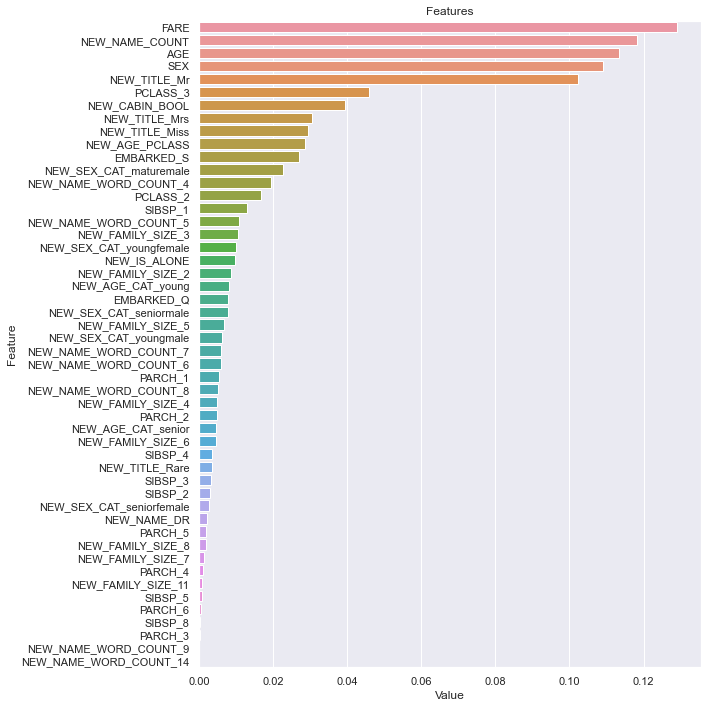

In [424]:
plot_importance(rfc, X_train)